# This is the synthetic experiment used in the online adaptive pca

### Load the libraries

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.io
import scipy as sp

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
%matplotlib inline

### synthetic data generating functions 

In [2]:
def gen_cov_mat(eigval_use,dim_n):
    """
    input: 
          eigval_use: the specified eigenvalues for the covariance matrix
          dim_n: each data sample's dimension or # feature
    output:
          Cov_1: generated covariance matrix
    """
    # This function is used to generate one covariance matrix
    # with specified eigenvalues
    H = rnd.randn(dim_n, dim_n)
    Q, R = np.linalg.qr(H)
    Cov_1 = np.dot(Q,np.dot(np.diag(eigval_use),Q.T))
    #print np.linalg.eigvals(Cov_1)
    return Cov_1

In [3]:
def gen_all_cov_mat(dim_n,rank_k,seg_num):
    """
    input:
          dim_n: each data sample's dimension or # feature
          rank_k: rank of each covariance matrix
          seg_num: number of different covariance matrices
    output:
          Cov_all: a list to store different covariance matrices
    """
    # This function is used to randomly generate all different covariance matrices
 
    idx_all = []
    Cov_all = []
    eigval_all = []
    for i in range(seg_num):
        idx_range = range(0,dim_n)
        rnd.shuffle(idx_range)
        idx_use = idx_range[:rank_k]
        idx_all.append(idx_use)
        eigval_gen = (1.*rnd.rand(1,dim_n)[0] +1.)/2. #scale to be [0.5,1]
        eigval_use = np.zeros((1,dim_n))[0]
        eigval_use[idx_use] = eigval_gen[idx_use]
        Cov_gen = gen_cov_mat(eigval_use,dim_n)
        Cov_gen = (Cov_gen + Cov_gen.T)/2.
        #print np.linalg.matrix_rank(Cov_gen)
        Cov_all.append(Cov_gen)
        eigval_all.append(eigval_use)
    #print idx_all
    #print eigval_all
    return Cov_all

In [4]:
def gen_data(Cov_all,dim_n,seg_num,data_num):
    """
    input:
          Cov_all: a list with different generated covariance matrices
          dim_n: each data sample's dimension or # feature
          seg_num: number of different covariance matrices
          data_num: number of data samples generated by each covariance matrix
    output:
          data_gen: synthetic data as a matrix with shape (dim_n,data_num*seg_num)
    """
    # This function is used to generate the data samples
    # based on different covariance matrices.
    # The order is: the first data_num samples are generated by
    # the first covariance matrix. Then the second size of these
    # is generated by the second covariance matrix, and so on.
    mean = np.zeros(dim_n)
    for i in range(seg_num):
        #print i
        Cov_use = Cov_all[i]
        #print np.linalg.matrix_rank(Cov_use)
        eigval = np.linalg.eigvals(Cov_use)
        #print eigval.real
        data_1 = rnd.multivariate_normal(mean, Cov_use, data_num)
        for j in range(data_num):
            if np.linalg.norm(data_1[j,:])>1.:
                data_1[j,:] = data_1[j,:]/np.linalg.norm(data_1[j,:])
        if i is 0:
            #print "initial data "
            data_gen = data_1.T
        else:
            #print "current step "
            #print j ,
            data_gen = np.hstack((data_gen,data_1.T))
            #print data_1
            #print data_gen
    return data_gen

### synthetic data generation setups 

In [5]:
n = 20 #data dimension
k = 2 #rank of the covariance
seg_num = 3 #number of different covariance matrix
data_num = 200 #number of data under each covariance
T = seg_num*data_num #total time or horizon
use_store_data = False # whether use already stored data
store_new_data = False # whether to store the new generated data
if use_store_data:
    load_data = scipy.io.loadmat('arrdata.mat')
    data_gen = load_data['data_gen']
else:
    Cov_all = gen_all_cov_mat(n,k,seg_num)
    data_gen = gen_data(Cov_all,n,seg_num,data_num)
if store_new_data:
    # you need to change the directory path to your own one
    scipy.io.savemat('/Users/Documents/online_adaptive_PCA/experiment/arrdata.mat',
                     mdict={'data_gen': data_gen})

In [6]:
data_gen.shape # this is the synthetic data shape (#feature, #samples)

(20, 600)

### Get the best fixed projection result: the batch PCA

In [7]:
#get the batch pca result
Cov_data = np.dot(data_gen,data_gen.T)
#print Cov_data.shape
eigvec_cov,eigval_cov,eigvec_covh = np.linalg.svd(Cov_data)
#eigval_sort_idx = np.argsort(eigval_cov)
#Proj_mat = np.dot(eigvec_cov[:,eigval_sort_idx[-k:]],eigvec_cov[:,eigval_sort_idx[-k:]].T)
Proj_mat = np.dot(eigvec_cov[:,:k],eigvec_cov[:,:k].T)
Proj_mat = Proj_mat.real
#get the step sum cost
batch_step_cost = np.zeros(T)
for i in range(T):
    data_ob = data_gen[:,i]
    batch_step_cost[i] = (np.linalg.norm(data_ob-np.dot(Proj_mat,data_ob)))**2
batch_cost_step_sum = np.cumsum(batch_step_cost)

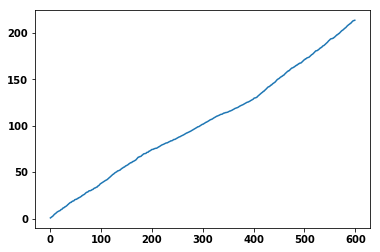

In [8]:
plt.plot(batch_cost_step_sum)

In [9]:
print eigval_cov # Check the eigenvalues' information to explain the failure of batch PCA

[1.44810583e+02 9.16410797e+01 7.79436149e+01 6.27130162e+01
 4.94685765e+01 2.33555255e+01 4.13723141e-14 3.29695387e-14
 2.46543718e-14 2.23175864e-14 1.86092680e-14 1.53692641e-14
 1.45109593e-14 1.11958310e-14 9.07576581e-15 7.82910881e-15
 6.36242413e-15 5.86091365e-15 3.49415475e-15 2.12134494e-15]


### Mixture decomposition function: Algorithm 2 in the paper

In [10]:
def mixture_decompose_lift(w_input,n,k):
    """
    input: 
          w_input: the eigenvalues/singular values vector for the decomposition
          n: data sample dimension or # features
          k: the rank of our desired projection matrix
    output:
          r_all: all decomposed corners with n-k non-zero elements equal to 1
                 Note: Here instead of the value of 1/(n-k) used in the algorithm 2 in paper, 
                       we lift it to 1 in order to avoid the small value resulted from 1/(n-k)
          p_all: each corner's associated coefficient in [0,1] in order to do the sampling
    """
    # Note: the input w_input is already lifted be in the range [0,n-k]
    
    #print "start decompose"
    d = n-k
    p_all = []
    r_all = []
    #w_input = 1./n*np.ones(n)
    w_use = w_input
    count_num = 0
    #print "mixture decompose: "
    p = 1.
    #while np.sum(w_use)/d>1e-5:
    while p>1e-7:
        #print count_num ,
        #print np.sum(w_use)/d
        #print w_use
        count_num = count_num + 1
        diff_corner_val0 = w_use-np.sum(w_use)/d 
        if np.all(diff_corner_val0<=-1e-6):# the case when no components equal to w/d
            #randomly select a corner
            #print "go in random"
            # to avoid selecting the one with 0 probability
            idx_corner = rnd.choice(len(w_use),size=d,replace = False, p=w_use/np.sum(w_use))
            w_no_select = np.abs(w_use-0.)
            w_no_select[idx_corner] = 0.
            r = np.zeros(n)
            r[idx_corner] = 1.
            s = np.amin(w_use[idx_corner])
            l = np.amax(w_no_select)
            p = np.minimum(s,np.sum(w_use)/d-l) 
            p_all.append(p)
            r_all.append(r)
            w_next = w_use - p*r
            w_use = w_next
        else: # the case when some components equal to w/d
            idx_gen = range(n)
            # get the needed corner
            diff_corner_val1 = np.abs(w_use-(np.sum(w_use)/d))
            idx_init_corner = list(np.where(diff_corner_val1<=1e-6)[0]) 
            if len(idx_init_corner)==0:
                print "error in decomposition "
            idx_corner_part = [idx_gen[ii] for ii in idx_init_corner] # initial index of the corner
            # check if corner idx is enough
            if len(idx_corner_part)<d: # the case when the # components equal to w/d is smaller than d
                                       # we need to get more
                diff_num = d-len(idx_corner_part)# get the additional # components needed
                diff_corner_val2 = np.abs(w_use-(np.sum(w_use)/d))
                idx_init_no_corner = list(np.where(diff_corner_val2>1e-6)[0])# get the unsatisfied index smaller than w/d
                p_no_corner_part = [w_use[jj] for jj in idx_init_no_corner] #extract the unsatisfied index of w
                pp_test = np.array(np.abs(np.array(p_no_corner_part)-0))
                pp_test_asd_idx = np.argsort(pp_test)
                pp_test_dsd_idx = pp_test_asd_idx[::-1]
                if pp_test[pp_test_dsd_idx[diff_num-1]]<1e-8:# check whether the highest unsatisfied component 
                                                             # of w is very close to 0, then no need to further process
                    break
                # randomly select the remaining # of index to add to corner index based on their value in w
                idx_no_corner_choice = rnd.choice(len(p_no_corner_part),size=diff_num,
                                            replace = False, p=p_no_corner_part/np.sum(p_no_corner_part))
                idx_init_no_corner = np.array(idx_init_no_corner)
                idx_corner_add_part = idx_init_no_corner[idx_no_corner_choice]
                idx_corner = np.hstack((idx_corner_part,idx_corner_add_part)) # the final corner
                w_no_use = np.array(p_no_corner_part)
                w_no_use[idx_no_corner_choice] = 0.
                l = np.amax(w_no_use)
            else: # the case when there are enough components equal to w/d
                idx_corner = idx_corner_part 
                l = 0.
            r = np.zeros(n)
            r[idx_corner] = 1.
            s = np.amin(w_use[idx_corner])
            p = np.minimum(s,np.sum(w_use)/d-l)
            p_all.append(p)
            r_all.append(r)
            w_next = w_use - p*r
            w_use = w_next
        if count_num>3*n: 
            print "too many steps for decomposition, something wrong"
            print w_input
            break
    return r_all,p_all


### Capping algorithm function: Algorithm 3 in paper

In [11]:
def capping_alg_lift(w,n,k):
    """
    input:
          w: the eigenvalue or singular value vector that needs to be capped
          n: the data dimension or # feature
          k: the rank of our desired projection matrix
    output:
          the capped w with each component in the range [0,1]
    """
    d = n-k
    d_upper = 1.
    w_lift = w*d # we lift the input to make each component in the range [0,d]
    if np.all(w_lift<1./d_upper+1e-7): # the case when the input w already satisfies the capping constraint
        #print "no capping "
        w_lift[np.where(np.abs(w_lift)<1e-10)] = 1e-10
        return w_lift
    
    else: # the case when the input w not satisfies the capping constraint
        idx_asd = np.argsort(w_lift)
        idx_dsd = idx_asd[::-1]
        w_lift_dsd = w_lift[idx_dsd]
    w_tilde = w_lift_dsd
    i = 1
    while np.max(w_tilde)>1./d_upper+1e-7:
        w_tilde = np.zeros(n)
        w_tilde[:i] = 1./d_upper
        sum_remain = np.sum(w_lift_dsd[i:])
        for j in range(i,n):
            w_tilde[j] = (d-i)*w_lift_dsd[j]/sum_remain
        i = i +1

    w_return = np.zeros(n)
    w_return[idx_dsd] = w_tilde
    #let the minimum of w_return to be bigger than 1e-10
    w_return[np.where(np.abs(w_return)<1e-10)] = 1e-10
    return w_return

### test the capping alg

In [12]:
##test the capping alg
#w_input = np.array([1./17,1./38,1./36,1./72,
#                   1./36,1./33,1./36,1./43,3./48,1./54])
#w_input = w_input/np.sum(w_input)
#print w_input
#w_input = capping_alg_lift(w_input,10,2)
#print w_input
#print 1./(10-2)
#print "start mixture decomposition "
#r_all,p_all = mixture_decompose_lift(w_input,10,2)
#print "done"

#print np.sum(p_all)
#for i_w in range(len(p_all)):
#    if i_w is 0:
#        w_out = r_all[i_w]*p_all[i_w]
#    else:
#        w_out = w_out + r_all[i_w]*p_all[i_w]
#print w_input-w_out
#print r_all

### Follow the Leader algorithm

In [13]:
def follow_the_leader(k,data_gen,T):
    """
    input: 
          k: the rank of our desired projection matrix
          data_gen: the synthetic data with shape (#feature, #samples)
          T: time horizon
    output:
          cumulative loss or regret
    """
    step_cost_ftl = np.zeros(T)
    print "follow the leader starts:"
    for tt in range(T):
        if tt<k:
            continue
        else:
            Cov_data_ftl = np.dot(data_gen[:,:tt],data_gen[:,:tt].T)
            eigvec_cov_ftl,eigval_cov_ftl,eigvec_covh_ftl = np.linalg.svd(Cov_data_ftl)
            Proj_mat_ftl = np.dot(eigvec_cov_ftl[:,:k],eigvec_cov_ftl[:,:k].T)
            data_ob = data_gen[:,tt]
            step_cost_ftl[tt] = (np.linalg.norm(data_ob-np.dot(Proj_mat_ftl,data_ob)))**2    
    print "follow the leader done"
    return np.cumsum(step_cost_ftl)

### online PCA or static online PCA 

In [14]:
def static_pca_online(n,k,eta,alpha,data_gen,T):
    # although the function name is static_pca_online,
    # it is also used in adaptive pca, since the later one augments the previous one.
    """
    input:
          n: the data dimension or # feature
          k: the rank of our desired projection matrix
          eta: the stepsize used in step (14a)
          alpha: the fixed-share value in step (14b). For static PCA, it is 0. For adaptive PCA, it is non-zero
          data_gen: the synthetic data with shape (#feature, #samples)
          T: time horizon
    """
    W_init = (1.*(n-k)/n)*np.eye(n)
    W_cur = W_init
    step_cost_static_pca = np.zeros(T) # one time step cost resulted from sampling of the corners
    exp_cost_static_pca = np.zeros(T) # expected step cost
    print "online pca starts: "
    for tt in range(T):
        if tt%100 == 0:
            print tt ,
        # get the eigen-decomposition result
        if tt is 0:
            eigvec_W_cur,eigval_W_cur,eigvec_W_cur_h = np.linalg.svd(W_cur)
        else:
            eigvec_W_cur = eigvec_W_hat
            eigval_W_cur = eigval_W_hat_cap_lift
        # call the mixture decomposition function
        r_candidate,p_dist = mixture_decompose_lift(eigval_W_cur,n,k)
        # randomly select the corner
        idx_pick = rnd.choice(len(p_dist),p = p_dist/np.sum(p_dist))
        r_corner = r_candidate[idx_pick]
        if np.abs(np.sum(r_corner)-(n-k))>1e-6:
            print "wrong corner "
        Mat_corner = np.dot(eigvec_W_cur,np.dot(np.diag(r_corner),eigvec_W_cur.T))
        # get the projection matrix
        Proj_use_mat = np.eye(n) - Mat_corner
        # get the data sample
        x_cur = data_gen[:,tt]
        # get the project loss
        step_loss = (np.linalg.norm(x_cur-np.dot(Proj_use_mat,x_cur)))**2.
        step_cost_static_pca[tt] = step_loss
        exp_cost_static_pca[tt] = np.trace(np.dot(W_cur,np.outer(x_cur,x_cur)))
        # some error tests
        if np.any(eigval_W_cur<0.):
            print "negative eigval of W_cur!!!"
            print "the most negative value is "
            print np.amin(eigval_W_cur) ,
        if np.any(np.iscomplex(W_cur)):
            print "W_cur is complex matrix!!!"        
        if not np.all(np.isfinite(W_cur)):
            print "W_cur is not finite!"
            scipy.io.savemat('/Users/Documents/online_adaptive_PCA/experiment/W_cur.mat',
                     mdict={'W_cur': W_cur}) 
        # this seems wrong, but the minus part is due to avoid log(0)
        logm_W_cur_cap = sp.linalg.logm(W_cur) - np.log(n-k)*np.eye(n)
        if np.any(np.iscomplex(logm_W_cur_cap)):
            print "logm_W_cur_cap is complex matrix !"
            scipy.io.savemat('/Users/liudingyi/Documents/online_adaptive_PCA/experiment/W_cur.mat',
                     mdict={'W_cur': W_cur})
        W_hat = sp.linalg.expm(logm_W_cur_cap-eta*np.outer(x_cur,x_cur))
        # some error tests
        if np.any(np.iscomplex(W_hat)):
            print "W_hat is complex matrix!!!"
            break
        if not np.all(np.isfinite(W_hat)):
            print "W_hat is not finite!"
            scipy.io.savemat('/Users/Documents/online_adaptive_PCA/experiment/W_hat.mat',
                     mdict={'W_hat': W_hat})    
            break
        W_hat_svd = (n-k)*W_hat/np.trace(W_hat)
        W_hat_svd = (W_hat_svd + W_hat_svd.T)/2.
        # add identity matrix to avoid computation precision near 0
        W_hat_svd_off_1 = W_hat_svd + np.eye(n)
        eigvec_W_hat, eigval_W_hat_svd_off1,eigvec_W_hat_h = sp.linalg.svd(W_hat_svd_off_1)
        # subtract the added identity eigenvalue
        eigval_W_hat_svd = np.abs(eigval_W_hat_svd_off1 - 1.)
        eigval_W_hat = eigval_W_hat_svd/(n-k)
        # the fixed-share step
        eigval_W_hat = (1-alpha)*eigval_W_hat + alpha/n 
        eigval_W_hat = eigval_W_hat/np.sum(eigval_W_hat) #make sure sum is 1.
        # call the capping algorithm
        eigval_W_hat_cap_lift = capping_alg_lift(eigval_W_hat,n,k)
        # error test
        if not np.all(eigval_W_hat_cap_lift<=1.+1e-6):
            print "wrong capping"
        # construct the new density matrix
        W_next = np.dot(eigvec_W_hat,np.dot(np.diag(eigval_W_hat_cap_lift),eigvec_W_hat.T))
        W_cur = W_next
    print "online pca done "
    return np.cumsum(step_cost_static_pca),np.cumsum(exp_cost_static_pca)

### different algorithms's setup and test

In [15]:
# determine stepsize, since k<=n/2, we can use D = (n-k)log(n/(n-k))
print "n is "
print n
print "k is "
print k
D_upper = (n-k)*np.log(n*1./(n-k))
D_upper_static = k*np.log(n*1./k)
print "D is "
print D_upper
L_upper = batch_cost_step_sum[-1]
print "L is "
print L_upper
eta_static = np.log(1+np.sqrt(2.*D_upper_static/L_upper))
print "static pca stepsize is "
print eta_static
eta_static = 1.
eta_adaptive = np.log(1+np.sqrt(2.*D_upper/L_upper))
alpha = 1./(1+T*(n-k))
alpha = 0.00001 # the fixed-share value can be set heuristically
print alpha
eta_static = 1. # the stepsize for static online pca
eta_adaptive = 1. # the stepsize for adaptive online pca

n is 
20
k is 
2
D is 
1.8964892818408743
L is 
213.48073311729274
static pca stepsize is 
0.18872643671886297
1e-05


### run the two online pca algorithms

In [16]:
trial = 5 # the number of runs for each algorithm
num_comp = 4 # the number of algorithms in the experiment
cumsum_cost_pca = np.zeros((num_comp,trial,T)) # matrix to store all the loss results
for tr_i in range(trial):
    #print tr_i ,
    cumsum_cost_pca[0,tr_i,:], exp_cost_static_pca = static_pca_online(n,k,eta_static,0,data_gen,T)
    cumsum_cost_pca[1,tr_i,:], exp_cost_adaptive_pca = static_pca_online(n,k,eta_adaptive,alpha,data_gen,T)
print "done"

online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
online pca starts: 
0 100 200 300 400 500 online pca done 
done


### get the follow the leader and batch pca results

In [17]:
cumsum_cost_pca_mean = np.zeros((num_comp,T))
for num_comp_i in range(num_comp-2):
    cumsum_cost_pca_mean[num_comp_i,:] = cumsum_cost_pca[num_comp_i,:,:].mean(axis=0)
cumsum_cost_pca_mean[2,:] = batch_cost_step_sum
cumsum_cost_pca_mean[-1,:] = follow_the_leader(k,data_gen,T)

follow the leader starts:
follow the leader done


### plot the different algorithms' results

In [18]:
def plot_total_loss(plot_list,T_list,Loss_list):
    fig,ax = plt.subplots(1,1,sharex=True,figsize=(5,5),squeeze=False)
    colors = ['b:','g--','r','k']

    labels = ['Online PCA', 'Online Adaptive PCA',
              'Best fixed Projection','Follow the Leader']
    titles = ['Total Loss Comparison']
    ax = ax.flatten()
    for conf_i in plot_list:
        ax[0].plot(T_list,Loss_list[conf_i,:],colors[conf_i],\
                       label = labels[conf_i],linewidth = 4,markersize=10)

    ax[0].legend(loc = 2)   
    plt.xlabel('Time Step',fontsize = 14, fontweight='bold')
    plt.ylabel('Total Loss',fontsize = 14, fontweight='bold')
    #plt.savefig('subspace_synthetic_online_comp.pdf',bbox_inches='tight',transparent=True,type ='pdf')

### two online pca comparison

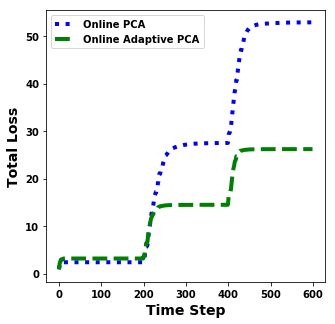

In [19]:
T_list = range(T)
plot_list = range(num_comp)
plot_list = range(2)
Loss_list = cumsum_cost_pca_mean
plot_total_loss(plot_list,T_list,Loss_list)

### all algorithms' comparison

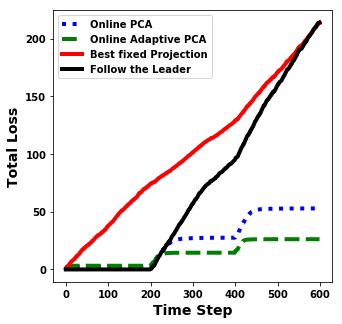

In [20]:
T_list = range(T)
plot_list = range(num_comp)
plot_list = range(4)
Loss_list = cumsum_cost_pca_mean
plot_total_loss(plot_list,T_list,Loss_list)